In [1]:
from common.ETLBase import ETLPro, SelectResult
class DataNode(ETLPro):
    def __init__(self, process_name, pre_request_etls, result_dir=None, **kwargs):
        super(DataNode, self).__init__(process_name, pre_request_etls, result_dir=result_dir)
        self.kwargs = kwargs
        
    def set_process(self, current_process):
        self.current_process = current_process 
    def set_n_out(self, n_out):
        self.n_out = n_out 
    def process(self, inputs):
        result = self.current_process(*inputs, **self.kwargs)
        if self.n_out == 1:
            return [result]
        else:
            return result
from pyflow import GraphBuilder
class PipelineBuilder():
    
    def __init__(self):
        self.current_process = None 
        self.current_process_name = None
        self.pyflow_GB = GraphBuilder()
        
    def add(self, process, method_alias=None, output_alias=None, result_dir=None, 
            n_out=1, rank=None, color='lightblue', shape=None, fontsize=None):
        self.current_process = process
        self.current_process_name = process.__name__
        self.n_out = n_out
        
        if type(result_dir) == list: 
            assert len(result_dir) == n_out
            for out, path in zip(output_alias, result_dir):
                assert out == path.split("/")[-1].split(".")[0]
        if result_dir:
            color = 'pink'
        self.result_dir = result_dir
        
        self.pyflow_GB.add(process, 
                           method_alias = method_alias, 
                           output_alias = output_alias,
                           n_out = n_out,
                           rank = rank,
                           color = color,
                           shape = shape,
                           fontsize = fontsize
                          )
        
        return self
    def __call__(self, *args, **kwargs):
        assert self.current_process
        assert self.current_process_name
        
        
        pf_input = [arg.pf_output_node for arg in args]
        pf_output = self.pyflow_GB(*pf_input, **kwargs)
        
        process_module = DataNode(
            self.current_process_name,
            list(args),
            result_dir = self.result_dir,
            **kwargs
        )
        
        process_module.set_process(self.current_process)
        process_module.set_n_out(self.n_out)
        
        if self.n_out > 1:
            
            outs = []
            for i, pf_output_node in zip(range(self.n_out), pf_output):
                
                out = SelectResult(
                self.current_process_name + f'[{i}]',
                [process_module],
                selected_indices=[i])
                out.set_pf_output_node(pf_output_node)
                
                outs.append(out)
                
            return outs
            
        else:
            process_module.set_pf_output_node(pf_output)
            return process_module 
    def view(self, summary=True, graph_attributes=None, verbose=False, gap=None):
        return self.pyflow_GB.view(
            summary=summary, 
            graph_attributes=graph_attributes, 
            verbose=verbose, 
            gap=gap
        )

# Functions

In [2]:
import numpy as np
import random 
from time import time 
import pandas as pd
import gc
from tqdm import tqdm
def load_chids(chid_file=None):
    assert chid_file 
    chid_array = np.loadtxt(chid_file, dtype=np.str)
    return chid_array

def sample_chids(chids, n_sample = 50000):
    if type(n_sample) == int:
        return random.sample(chids.tolist(), n_sample)
    else:
        return chids.tolist()
    
def build_chid_to_nid_map(chids_list):
    chid_to_nid_map = dict([(v,k) for k, v in enumerate(chids_list)])
    return chid_to_nid_map

def load_cdtx(chids, cdtx_file = None):
    assert cdtx_file
    t0 = time()
    df_cdtx = pd.read_csv(cdtx_file, skipinitialspace=True)
    df_cdtx = df_cdtx[df_cdtx.chid.isin(chids)]
    # df_cdtx.csmdt.apply(lambda x: x[:-len('T00:00:00.000Z')])
    df_cdtx.sort_values(by=['csmdt', 'chid'], inplace=True, ignore_index=True)
    # df_cdtx.objam = df_cdtx.objam.astype(np.int64)
    print('loading time:', time() - t0)
    # checking
    assert len(set(df_cdtx.chid) - set(chids)) == 0 \
        and len(set(chids) - set(df_cdtx.chid)) == 0
    assert type(df_cdtx.objam[0]) == np.int64
    assert len(df_cdtx.csmdt[0]) == 10
    return df_cdtx



def load_cust_f(chids, cust_f_file = None):
    assert cust_f_file 
    t0 = time()
    df_cust_f = pd.read_csv(cust_f_file, skipinitialspace=True)
    df_cust_f = df_cust_f[df_cust_f.chid.isin(chids)]
    df_cust_f.sort_values(
        by=['data_dt', 'chid'],
        inplace=True,
        ignore_index=True
    )
    df_cust_f.drop_duplicates(ignore_index=True, inplace=True)
    print('loading time:', time() - t0)
    assert len(set(df_cust_f.chid) - set(chids)) == 0 \
        and len(set(chids) - set(df_cust_f.chid)) == 0
    return df_cust_f


def convert_uid_to_nid(df_input, chid_to_nid_map):
    df_input.chid = df_input.chid.map(chid_to_nid_map) + 1
    return df_input

def add_month(df_cdtx):
    df_cdtx['month'] = df_cdtx.csmdt.apply(lambda x: x[:-3] + '-01')
    return df_cdtx

def make_chid_x_month_table(df_cdtx):
    '''
    產生一個包含所有顧客與所有月份的一個table。column的數量為: (# chids) X (# months)
    '''
    df_cdtx
    list_chid = sorted(df_cdtx.chid.unique())
    list_month = sorted(df_cdtx.month.unique())[:]
    print('list_chid, list_month calculated')
    del df_cdtx
    print('[DELETE] df_cdtx')
    gc.collect()

    df_full_y_sum = pd.DataFrame({
        'chid': list_chid * len(list_month),
    }).sort_values(by='chid', ignore_index=True)  # 讓list_chid重複的次數和月的數量一樣多
    df_full_y_sum['data_dt'] = list_month * len(list_chid)  # 讓list_month重複出現的次數和顧客數一樣多

    return df_full_y_sum


def calculate_monthly_target(df_cdtx):

    for col in set(df_cdtx.columns) - set(['chid', 'month', 'objam']):
        del df_cdtx[col]
        gc.collect()

    shrinked_df_cdtx = df_cdtx

    cdtx_group = shrinked_df_cdtx.groupby(['chid', 'month'])
    print('df_cdtx grouped')
    del shrinked_df_cdtx
    gc.collect()

    cdtx_sum = cdtx_group.sum()  # 總金額
    cdtx_mean = cdtx_group.mean()  # 平均金額
    cdtx_count = cdtx_group.count()  # 消費次數
    del cdtx_group
    gc.collect()

    # TODO: implement the loading of stonc_6_label
    # cdtx_group = df_cdtx[['chid', 'month', 'stonc_6_label']].drop_duplicates().groupby(['chid', 'month'])
    # cdtx_shop_kind_count = cdtx_group.count()

    # del cdtx_group
    # gc.collect()

    # del df_cdtx
    # gc.collect()

    df_cdtx_objam = pd.DataFrame(list(map(list, cdtx_sum.index)), columns=['chid', 'data_dt'])
    df_cdtx_objam['objam_sum'] = cdtx_sum.values[:, 0]
    df_cdtx_objam['objam_mean'] = cdtx_mean.values[:, 0]
    df_cdtx_objam['trans_count'] = cdtx_count.values[:, 0]  # 交易次數

    # df_cdtx_objam['shop_count'] = cdtx_shop_kind_count.values[:, 0] # 一個月內消費店家種類個數

    del cdtx_sum, cdtx_mean, cdtx_count  # , cdtx_shop_kind_count
    gc.collect()
    return df_cdtx_objam


def merge_with_another_table(df_full_y_sum, df_to_be_merged, join_method = 'left'):
    df_full_y_sum = df_full_y_sum.merge(df_to_be_merged,
                                        how=join_method,
                                        left_on=['chid', 'data_dt'],
                                        right_on=['chid', 'data_dt']).fillna(0)
    return df_full_y_sum

def add_mean_of_previous_two_months(df_full_y_sum):
    # 本月 前1、2月 平均金額
    df_full_y_sum.insert(6, 'objam_mean_M3', 0)
    for chid in tqdm(sorted(df_full_y_sum.chid.unique())):
        mask = df_full_y_sum.chid == chid

        temp = (df_full_y_sum.loc[mask, 'objam_sum'] +
                df_full_y_sum.loc[mask, 'objam_sum'].shift(1).fillna(0) +
                df_full_y_sum.loc[mask, 'objam_sum'].shift(2).fillna(0)) // 3

        df_full_y_sum.loc[mask, 'objam_mean_M3'] = temp
        gc.collect()
    return df_full_y_sum

def cast_time_column_to_np_datatime64(df_full_y_sum, time_column='data_dt'):
    df_full_y_sum[time_column] = df_full_y_sum[time_column].astype(np.datetime64)
    return df_full_y_sum

def add_duration_since_20180101(df_cdtx, time_column='csmdt', result_column='timestamp_1'):
    df_cdtx[result_column] = (
        df_cdtx[time_column] - np.datetime64('2018-01-01')
    ).values / np.timedelta64(1, 'D')
    df_cdtx[result_column].fillna(0)
    return df_cdtx

def add_duration_since_last_trans(df_cdtx, time_column = 'csmdt', result_column='timestamp_0'):
    df_cdtx[result_column] = (df_cdtx[time_column] - df_cdtx[time_column].shift()).values / np.timedelta64(1, 'D')
    df_cdtx[result_column] = df_cdtx[result_column].fillna(0)
    df_cdtx.sort_values(by=['chid', time_column], ignore_index=True, inplace=True)
    mask_list = []
    chid_pre = -1
    for i, chid in tqdm(enumerate(df_cdtx.chid.values)):
        if chid != chid_pre:  # 不是-1，也不是前一個chid，代表是沒有算到另一個chid的前一次時間。
            chid_pre = chid
            mask_list.append(i)

    df_cdtx.loc[mask_list, result_column] = 0
    return df_cdtx

def add_objam_mean_M3_diff_as_new_target(df_y, y_train, y_test):
    y_columns = list(df_y)
    y_columns[-1] = 'objam_mean_M3_diff'

    y_train[:, -1] = y_train[:, 2] - y_train[:, -1]
    y_test[:, -1] = y_test[:, 2] - y_test[:, -1]
    return y_train, y_test, y_columns

def extract_feature_cols_and_encode_categoricals(df_original, category_cols=[], numeric_cols=[]):
    df_result = df_original[category_cols + numeric_cols]
    del df_original
    gc.collect()
    print('table extracted')
    for col in category_cols[1:]:
        if type(df_result[col][0]) == str:
            df_result[col] = df_result[col].fillna('')
            print(col, 'na filled')
        elif type(df_result[col][0]) == np.int64:
            df_result[col] = df_result[col].fillna(-1)
            print(col, 'na filled')
        if type(df_result[col][0]) != str and type(df_result[col][0]) != np.int64:
            df_result[col] = df_result[col].values.astype(np.str)
            print(col, 'type casted')
        gc.collect()
    print('all non str category col casted')
    mapper = {col: {value: index + 1 for index, value in enumerate(sorted(df_result[col].unique()))}
              for col in category_cols[1:]}
    print('mapper created')

    for col in category_cols[1:]:
        df_result[col] = df_result[col].map(mapper[col])
        gc.collect()
        print(col, 'map applied')
    return df_result, mapper

def extract_target_columns(df_origin, target_cols = []):
    df_y = df_origin[target_cols].copy().reset_index(drop=True)
    del df_origin
    gc.collect()
    return df_y

def extract_x_f_y_columns(df_input, df_feat_input, y_columns):
    columns = {
        'x_columns': list(df_input),
        'f_columns': list(df_feat_input),
        'y_columns': y_columns,
    }
    return columns

def split_data(df_x, df_f, df_y, window_size=120, test_size=2):
    x_train, x_test, f_train, f_test, y_train, y_test = [], [], [], [], [], []

    for i in tqdm(sorted(df_y.chid.unique())):
        # 抓出各個顧客的資料
        data_x = df_x[df_x.chid == i].reset_index(drop=True)
        data_f = df_f[df_f.chid == i].reset_index(drop=True)
        data_y = df_y[df_y.chid == i].reset_index(drop=True)

        # 抓出某一顧客的最後一月的月份
        last = data_y.shape[0] - 1
        # 把資料的月份按照順序列出
        ts_list = sorted(data_y.timestamp.unique())

        for j, (ts_f, ts_y) in enumerate(zip(ts_list[:-1], ts_list[1:])):
            # ts_f是前一月 ts_y是下一個月
            data_x_ws = data_x[data_x.timestamp_1 < ts_y][-window_size:].copy()
            # 把和 ts_y 的差距月數作為新的時間因子
            data_x_ws.timestamp_1 = ts_y - data_x_ws.timestamp_1
            # 轉換為 np array
            data_x_ws = data_x_ws.values
            # 如果取的資料量比window_size還小，補進0
            if data_x_ws.shape[0] < window_size:
                tmp = np.zeros((window_size, data_x.shape[1]))
                if data_x_ws.shape[0] > 0:
                    tmp[-data_x_ws.shape[0]:] = data_x_ws
                data_x_ws = tmp

            if j < last - test_size:
                x_train.append(data_x_ws)
                # 取前一個月的顧客特徵
                f_train.append(data_f[data_f.timestamp == ts_f].values[0, :-1])
                # 往下一個月去取資料
                y_train.append(data_y.values[j + 1, :-1])
            elif j < last:
                x_test.append(data_x_ws)
                # 取前一個月的顧客特徵
                f_test.append(data_f[data_f.timestamp == ts_f].values[0, :-1])
                # 往下一個月去取資料
                y_test.append(data_y.values[j + 1, :-1])
            else:
                break
    x_train, x_test = np.array(x_train), np.array(x_test)
    f_train, f_test = np.array(f_train), np.array(f_test)
    y_train, y_test = np.array(y_train), np.array(y_test)
    return x_train, x_test, f_train, f_test, y_train, y_test

###########################################################################################################

from sklearn.preprocessing import MinMaxScaler
class GenerateSparseDenseSetting:
    def __init__(self, category_cols=[], sparse_feat=[], numeric_cols=[], dense_feat=[], USE_CHID=True):
        self.category_cols = category_cols
        self.sparse_feat = sparse_feat
        self.numeric_cols = numeric_cols
        self.dense_feat = dense_feat
        self.USE_CHID = USE_CHID

    def process(self, feat_mapper, chid_mapper):
        feat_mapper = self._remove_unused_sparse_feat_mapper(feat_mapper, self.sparse_feat)
        sparse_dims, sparse_index = self._get_sparse_dims(self.category_cols, self.sparse_feat, chid_mapper, feat_mapper, USE_CHID=self.USE_CHID)
        dense_dims, dense_index = self._get_dense_dims(self.numeric_cols, self.dense_feat)
        return sparse_dims, sparse_index, dense_dims, dense_index

    def _remove_unused_sparse_feat_mapper(self, feat_mapper, sparse_feat):
        keys = list(feat_mapper.keys())
        for key in keys:
            if key not in sparse_feat:
                del feat_mapper[key]
        return feat_mapper

    def _get_sparse_dims(self, category_cols, sparse_feat, chid_mapper, feat_mapper, USE_CHID=True, chid_embed_dim=64, feat_embed_dim=16):
        '''
        inputs:
         - sparse_feat: the selected sparse feature
         - USE_CHID: whether to include chid
         - chid_embed_dim: the dimension of user embedding
         - feat_embed_dim: the dimension of dense feature embedding

        outputs:
        - sparse_dims: a list of tuple, whether each tuple represent the shape of the embedding of the sparse feature.
            The first element of the tuple represents the number of class or id of the feature.
            The second element of the tuple represents the embedding dimension of the feature.
        '''
        idx_start = 1 - int(USE_CHID)
        sparse_index = [category_cols.index(feat) for feat in sparse_feat][idx_start:]

        # dense dims: the number of dense feature
        feat_dims = np.array([len(chid_mapper)] + [len(v) for v in feat_mapper.values()]) + 1  # 0 is padding index, so add 1 dims
        # feat_dims: a list where each element represent the class or id count of a feature
        embed_dims = [chid_embed_dim] + [feat_embed_dim] * len(feat_mapper)  # dims of chid and other sparse feature
        # the embedding dimension of each dense feature.
        sparse_dims = [(fd, ed) for fd, ed in zip(feat_dims[idx_start:], embed_dims[idx_start:])]
        # combine feat_dims and sparse_dims for later embedding layer construction
        return sparse_dims, sparse_index

    def _get_dense_dims(self, numeric_cols, dense_feat):
        dense_index = [numeric_cols.index(feat) for feat in dense_feat]
        dense_dims = len(dense_feat)
        return dense_dims, dense_index

class ProcessX:
    @staticmethod
    def process(x_train, x_test, sparse_index, dense_index):
        print('Processing x_train')
        x_scaler = MinMaxScaler(feature_range=(0, 1))
        x_train_sparse, x_train_dense = ProcessX._process_x_data(x_train, sparse_index, dense_index, x_scaler, mode='train')
        print('Processing x_test')
        x_test_sparse, x_test_dense = ProcessX._process_x_data(x_test, sparse_index, dense_index, x_scaler, mode='test')
        return x_train_sparse, x_train_dense, x_test_sparse, x_test_dense
    
    @staticmethod
    def _process_x_data(x, sparse_index, dense_index, x_scaler, mode='train'):
        w_size = x.shape[1]
        # window size of the time series data, x_train

        print('Split Sparse and Dense Parts and Apply np.float64 and np.int64, respectively')
        x_sparse = x[:, -w_size:, sparse_index].astype(np.int64)  # split sparse feature
        x_dense = x[:, -w_size:, dense_index].astype(np.float64)  # split dense feature
        gc.collect()
        print('apply Log(1+x) transformation to the dense features')
        x_dense = np.log1p(x_dense - x_dense.min(axis=0))
        gc.collect()
        print('apply MinMaxScale((0,1)) to the dense features')

        # transform:
        # 把前兩維濃縮為一維, 因為MinMaxScaler不支援三維以上Tensor
        # 還原為原本的shape
        if mode == 'train':
            x_dense = x_scaler.fit_transform(x_dense.reshape(-1, x_dense.shape[-1])).reshape(x_dense.shape)
        else:
            x_dense = x_scaler.transform(x_dense.reshape(-1, x_dense.shape[-1])).reshape(x_dense.shape)
        gc.collect()
        return x_sparse, x_dense
    
class ProcessY(ETLPro):
    @staticmethod
    def process(Y_train, Y_test, columns):
        objmean_scaler = MinMaxScaler((0, 1))
        train_objmean, train_tscnt, train_label_0 = ProcessY._process_y_data(Y_train, columns["y_columns"], objmean_scaler, mode='train')
        test_objmean, test_tscnt, test_label_0 = ProcessY._process_y_data(Y_test, columns["y_columns"], objmean_scaler, mode='test')
        return train_objmean, train_tscnt, train_label_0, test_objmean, test_tscnt, test_label_0
    @staticmethod
    def _process_y_data(Y, y_columns, objmean_scaler, mode='train'):
        '''
        input:
         - Y: Y tensor (e.g., Y_train or Y_test)
         - columns: the y_columns in saved columns
        output:
         - target tensors: objmean, tscnt, label_0
        '''
        print('Convert Numeric Y values to np.float64 for Regression')
        index = y_columns.tolist().index('objam_sum')
        objsum = Y[:, [index]].astype(np.float64)

        index = y_columns.tolist().index('objam_mean')
        objmean = Y[:, [index]].astype(np.float64)

        index = y_columns.tolist().index('trans_count')
        tscnt = Y[:, [index]].astype(np.float64)
        gc.collect()
        print('Apply Log(1+x) Transformation')

        objsum = np.log1p(objsum)
        objmean = np.log1p(objmean)
        tscnt = np.log1p(tscnt)
        gc.collect()
        print('Apply  MinMaxScaler((0,1)) to objmean')
        # TODO: why apply MinMaxScaler on obj mean?
        if mode == 'train':
            objmean = objmean_scaler.fit_transform(objmean)
        else:
            objmean = objmean_scaler.transform(objmean)
        gc.collect()
        # classfication :
        print('Convert objsum to class target: whether or not objsum > 0 ')
        bounds = [0]
        lable_trans = np.vectorize(lambda x: sum([x > bound for bound in bounds]))
        label_0 = lable_trans(objsum)
        gc.collect()
        return objmean, tscnt, label_0
    
import torch 
from torch.utils.data import TensorDataset
def build_TensorDataset(x_dense, x_sparse, y_objmean, y_tscnt, y_label_0):
    dataset = TensorDataset(
        torch.FloatTensor(x_dense),
        torch.LongTensor(x_sparse),
        torch.FloatTensor(y_objmean),
        torch.FloatTensor(y_tscnt),
        torch.FloatTensor(y_label_0)  # .flatten()
    )
    return dataset


# Build Pipeline 

In [3]:
import os
origin_path = 'data/source'
sample_path = 'data/sample'
n_sample = 50
tmp_path = 'data/tmp' #  'data/tmp'
result_path = 'data/result' # 'data/result'
window_size = 120 
test_size = 2 
chid_file = os.path.join(origin_path, 'sample_chid.txt')
cdtx_file = os.path.join(origin_path, 'sample_zip_if_cca_cdtx0001_hist.csv')
cust_f_file = os.path.join(origin_path, 'sample_zip_if_cca_cust_f.csv')

numeric_cols = ['bnspt', 'timestamp_0', 'timestamp_1', 'objam'], 
category_cols = ['chid', 'bnsfg', 'iterm', 'mcc', 'scity'], 
dense_feat = ['bnspt', 'timestamp_0', 'timestamp_1', 'objam'], 
sparse_feat = ['chid', 'bnsfg', 'iterm', 'mcc', 'scity'], 
USE_CHID = True

sparse_dense_setting_generator = GenerateSparseDenseSetting(
    category_cols=category_cols, 
    sparse_feat=sparse_feat, 
    numeric_cols=numeric_cols, 
    dense_feat=dense_feat, 
    USE_CHID=USE_CHID
)

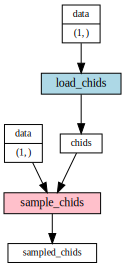

In [4]:
PB_0 = PipelineBuilder()
chids = PB_0.add(load_chids, output_alias = 'chids')(chid_file = chid_file)

sampled_chids = PB_0.add(
    sample_chids, 
    output_alias = 'sampled_chids', 
    result_dir = os.path.join(sample_path,'chid_to_nid_map.npy')
)(chids, n_sample = 50)
PB_0.view(summary = False)

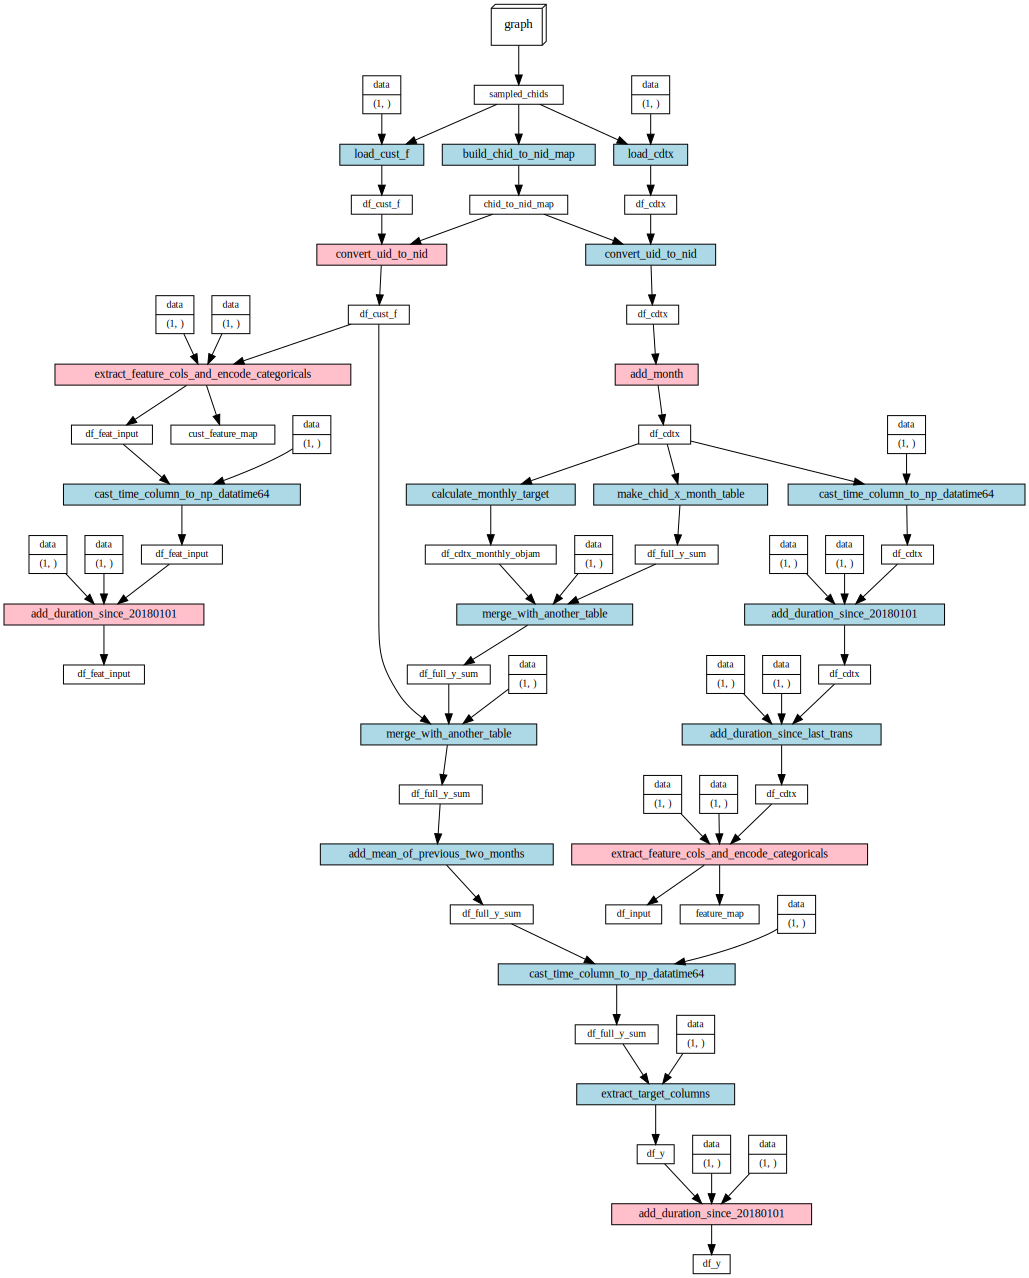

In [5]:

PB = PipelineBuilder()
chid_to_nid_map = PB.add(build_chid_to_nid_map, output_alias = 'chid_to_nid_map')(
    sampled_chids
)
df_cdtx = PB.add(load_cdtx, output_alias = 'df_cdtx')(
    sampled_chids, 
    cdtx_file = cdtx_file
)
df_cdtx = PB.add(convert_uid_to_nid, output_alias = 'df_cdtx')(
    df_cdtx, 
    chid_to_nid_map
)
df_cdtx = PB.add(add_month, 
                 output_alias = 'df_cdtx', 
                 result_dir = os.path.join(tmp_path, 'df_cdtx.feather')
                )(df_cdtx)

df_full_y_sum = PB.add(
    make_chid_x_month_table, 
    output_alias = 'df_full_y_sum'
)(
    df_cdtx
)


df_cdtx_monthly_objam = PB.add(calculate_monthly_target, output_alias = 'df_cdtx_monthly_objam')(
    df_cdtx
)

df_full_y_sum = PB.add(merge_with_another_table, output_alias = 'df_full_y_sum')(
    df_full_y_sum, 
    df_cdtx_monthly_objam, 
    join_method='left'
)

df_cust_f = PB.add(load_cust_f, output_alias = 'df_cust_f')(
    sampled_chids, 
    cust_f_file = cust_f_file
)

df_cust_f = PB.add(
    convert_uid_to_nid, 
    output_alias = 'df_cust_f', 
    result_dir = os.path.join(tmp_path, 'df_cust_f.feather')
)(
    df_cust_f, 
    chid_to_nid_map
)

df_full_y_sum = PB.add(merge_with_another_table, output_alias = 'df_full_y_sum')(
    df_full_y_sum, df_cust_f, join_method='inner')

df_full_y_sum = PB.add(add_mean_of_previous_two_months, output_alias = 'df_full_y_sum')(
    df_full_y_sum)



df_full_y_sum = PB.add(cast_time_column_to_np_datatime64, output_alias = 'df_full_y_sum')(
    df_full_y_sum, time_column = 'data_dt')

df_cdtx = PB.add(cast_time_column_to_np_datatime64, output_alias = 'df_cdtx')(
    df_cdtx, time_column = 'csmdt')


df_cdtx = PB.add(add_duration_since_20180101, output_alias = 'df_cdtx')(
    df_cdtx, time_column = 'csmdt', result_column='timestamp_1')


df_cdtx = PB.add(add_duration_since_last_trans, output_alias = 'df_cdtx')(
    df_cdtx, time_column = 'csmdt', result_column='timestamp_0')


df_input, feature_map = PB.add(
    extract_feature_cols_and_encode_categoricals, 
    n_out = 2, 
    output_alias = ['df_input', 'feature_map'], 
    result_dir=[
                os.path.join(tmp_path, 'df_input.feather'),
                os.path.join(tmp_path, 'feature_map.npy')
            ]
)(
    df_cdtx, 
    numeric_cols=['bnspt', 'timestamp_0', 'timestamp_1', 'objam'],
    category_cols=['chid', 'bnsfg', 'iterm', 'mcc', 'scity']
)

df_feat_input, cust_feature_map = PB.add(
    extract_feature_cols_and_encode_categoricals, 
    n_out = 2, 
    output_alias = ['df_feat_input', 'cust_feature_map'], 
    result_dir=[
                os.path.join(tmp_path, 'df_feat_input.1.feather'),
                os.path.join(tmp_path, 'cust_feature_map.npy')
            ]
)(
    df_cust_f, 
    numeric_cols=['slam', 'first_mob', 'constant_change', 'sum_l2_ind',
                  'sum_u2_ind', 'constant_l2_ind', 'constant_u4_ind',
                  'growth_rate', 'monotone_down', 'monotone_up', 'data_dt'],
    category_cols=['chid', 'masts', 'educd', 'trdtp', 'poscd']
)

df_feat_input = PB.add(cast_time_column_to_np_datatime64, output_alias = 'df_feat_input')(
    df_feat_input, time_column = 'data_dt')

df_feat_input = PB.add(
    add_duration_since_20180101, 
    output_alias = 'df_feat_input', 
    result_dir = os.path.join(tmp_path, 'df_feat_input.2.feather')
)(
    df_feat_input, time_column = 'data_dt', result_column='timestamp')



df_y = PB.add(extract_target_columns, output_alias = 'df_y')(
    df_full_y_sum,
    target_cols=['chid', 'data_dt', 'objam_sum', 'objam_mean', 'trans_count', 'objam_mean_M3'],  # 'shop_count'
)
df_y = PB.add(
    add_duration_since_20180101, 
    output_alias = 'df_y', 
    result_dir = os.path.join(tmp_path, 'df_y.feather')
)(
    df_y, time_column = 'data_dt', result_column='timestamp')

PB.view(summary=False)

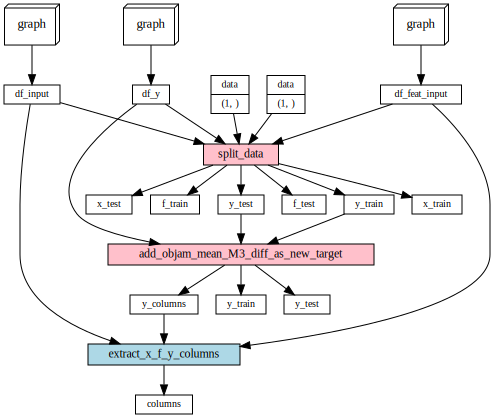

In [7]:

PB_1 = PipelineBuilder()
# split_data
# add_objam_mean_M3_diff_as_new_target
# extract_x_f_y_columns

x_train, x_test, f_train, f_test, y_train, y_test = PB_1.add(
    split_data, 
    n_out = 6,
    output_alias = ['x_train', 'x_test', 'f_train', 'f_test', 'y_train', 'y_test'],
    result_dir=[
                os.path.join(tmp_path, 'x_train.npy'),
                os.path.join(tmp_path, 'x_test.npy'),
                os.path.join(tmp_path, 'f_train.npy'),
                os.path.join(tmp_path, 'f_test.npy'),
                os.path.join(tmp_path, 'y_train.npy'),
                os.path.join(tmp_path, 'y_test.npy')
            ]
)(df_input, df_feat_input, df_y, window_size = window_size, test_size = test_size)


y_train, y_test, y_columns = PB_1.add(
    add_objam_mean_M3_diff_as_new_target, 
    n_out = 3,
    output_alias = ['y_train', 'y_test', 'y_columns'],
    result_dir = [
        os.path.join(tmp_path, 'y_train.npy'),
        os.path.join(tmp_path, 'y_test.npy'),
        os.path.join(tmp_path, 'y_columns.npy')
    ]
)(df_y, y_train, y_test)

columns = PB_1.add(extract_x_f_y_columns, output_alias = 'columns')(
    df_input, df_feat_input, y_columns
)


'''
for output in [x_train, x_test, f_train, f_test, y_train, y_test, columns, feature_map, cust_feature_map, chid_to_nid_map]:
    output.get()
'''
PB_1.view(summary=False)

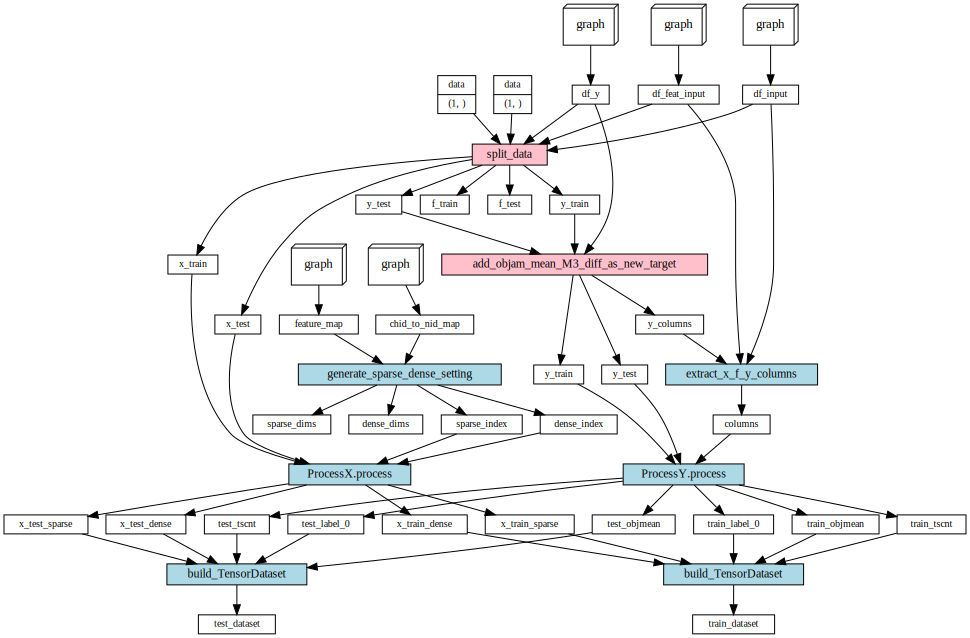

In [8]:

PB_2 = PB_1#PipelineBuilder()

sparse_dims, sparse_index, dense_dims, dense_index = PB_2.add(
    sparse_dense_setting_generator.process,
    method_alias = 'generate_sparse_dense_setting',
    n_out = 4, 
    output_alias = ['sparse_dims', 'sparse_index', 'dense_dims', 'dense_index']
)(
    feature_map, chid_to_nid_map
)

x_train_sparse, x_train_dense, x_test_sparse, x_test_dense = PB_2.add(
    ProcessX.process,
    method_alias = 'ProcessX.process',
    n_out = 4, 
    output_alias = ['x_train_sparse', 'x_train_dense', 'x_test_sparse', 'x_test_dense']
)(
    x_train, x_test, sparse_index, dense_index
)

train_objmean, train_tscnt, train_label_0, test_objmean, test_tscnt, test_label_0 = PB_2.add(
    ProcessY.process,
    method_alias = 'ProcessY.process',
    n_out = 6, 
    output_alias = ['train_objmean', 'train_tscnt', 'train_label_0', 'test_objmean', 'test_tscnt', 'test_label_0']
)(
    y_train, y_test, columns
)

train_dataset = PB_2.add(
    build_TensorDataset,
    output_alias = 'train_dataset'
)(
    x_train_dense, x_train_sparse, train_objmean, train_tscnt, train_label_0
)
    
test_dataset = PB_2.add(
    build_TensorDataset,
    output_alias = 'test_dataset'
)(
    x_test_dense, x_test_sparse, test_objmean, test_tscnt, test_label_0
)
PB_2.view(summary=False)

In [ ]:
# 